In [1]:
!pip install pyparsing==2.4.6

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
from src.core import Term, Atom
from src.ilp import Language_Frame, Program_Template, Rule_Template
from src.dilp import DILP
import tensorflow as tf
import numpy as np
from src.utils import process_file, process_dir, create_table, output_rules, test_rule, train, test
from src.generate_template import create_templates
import duckdb
tf.random.set_seed(1000)
np.random.seed(1000)

2024-05-17 18:54:14.198880: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 18:54:15.153545: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
con = duckdb.connect(':memory:')
# enable automatic query parallelization
con.execute("PRAGMA threads=2")
# enable caching of parquet metadata
con.execute("PRAGMA enable_object_cache")

## Rule template
 Rule_Template(v: int, allow_intensional: bool): 
v is number of existentially qualified variables(X,Y,Z...) in the clause

Program_Template(p_a: list, rules: dict, T: int):
 p_a {list} -- set of auxiliary predicates; these are the additional invented predicates used to help define the target predicate
 
 
 rules {tuple} -- Map of intensional predicate to a pair if rule templates 
 T {int} -- Max number of steps of forward chaining inference

In [4]:
# p_a = [Atom([term_x_0], 'pred')]
# target_rule = (Rule_Template(v=0, allow_intensional=True), None)
# p_a_rule_1 = (Rule_Template(v=0, allow_intensional=False), None)

# rules = {p_a[0]: p_a_rule_1, target: target_rule} 

## a, b learning

In [5]:
%%time 
input_dir = '../examples/a-b/'
input_table = create_table(con, input_dir)
target, p_e, constants, B, P, N = process_dir(input_dir)

# arity 1
term_x_0 = Term(True, 'X_0')
p_a, rules = create_templates(p_e, target, term_x_0)

# target_rule = (Rule_Template(v=0, allow_intensional=False), None)
# rules = {target: target_rule} 

language_frame = Language_Frame(target, p_e, constants)


96
end of facts processing
22
end of positive examples processing
52
end negative examples processing
data is in order
CPU times: user 37.6 ms, sys: 7.73 ms, total: 45.4 ms
Wall time: 43.7 ms


In [6]:
program_template = Program_Template(p_a, rules, T=2)
dilp = DILP(language_frame, B, P, N, program_template, allow_target_recursion=True)
dilp.show_definition()


----------------------------
Target(X_0)
Target(X_0) -> A(X_0),A(X_0)
None
----------------------------


[(Target(X_0) -> A(X_0),A(X_0), None)]

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 0.6098328828811646
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Target(45) Expected: 1 1.000
Target(44) Expected: 1 1.000
Target(59) Expected: 0 0.717
Target(95) Expected: 0 0.717
Target(69) Expected: 1 1.000
Target(14) Expected: 0 0.335
Target(64) Expected: 1 1.000
Target(76) Expected: 0 0.717
Target(92) Expected: 0 0.335
Target(51) Expected: 0 0.717
Target(33) Expected: 0 0.717
Target(15) Expected: 0 0.335
Target(93) Expected: 0 0.335
Target(21) Expected: 0 0.717
Target(25) Expected: 1 1.000
Target(36) Expected: 1 1.000
Target(41) Expected: 0 0.717
Target(43) Expected: 1 1.000
Target(22) Expected: 0 0.335
Target(66) Expected: 0 0.335
Target(5

'select "B" and "A" as "Target",\n'

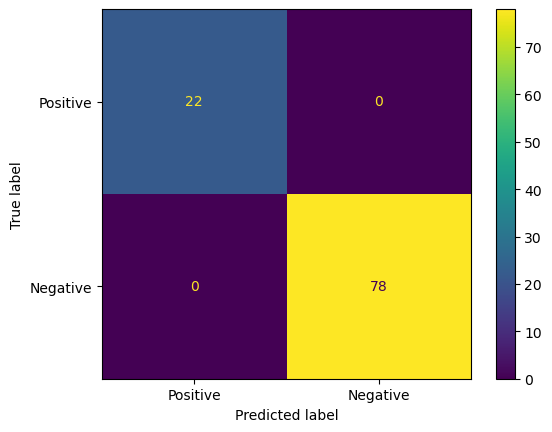

In [7]:
train(dilp)
test(dilp, input_table, con)

In [8]:
input_table['Target'].sum()/len(input_table)

0.22

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 0.41316816210746765
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Target(45) Expected: 1 1.000
Target(44) Expected: 1 1.000
Target(59) Expected: 0 0.425
Target(95) Expected: 0 0.425
Target(69) Expected: 1 1.000
Target(14) Expected: 0 0.467
Target(64) Expected: 1 1.000
Target(76) Expected: 0 0.425
Target(92) Expected: 0 0.467
Target(51) Expected: 0 0.425
Target(33) Expected: 0 0.425
Target(15) Expected: 0 0.467
Target(93) Expected: 0 0.467
Target(21) Expected: 0 0.425
Target(25) Expected: 1 1.000
Target(36) Expected: 1 1.000
Target(41) Expected: 0 0.425
Target(43) Expected: 1 1.000
Target(22) Expected: 0 0.467
Target(66) Expected: 0 0.467
Target(

'select "B" and "A" as "Target",\n'

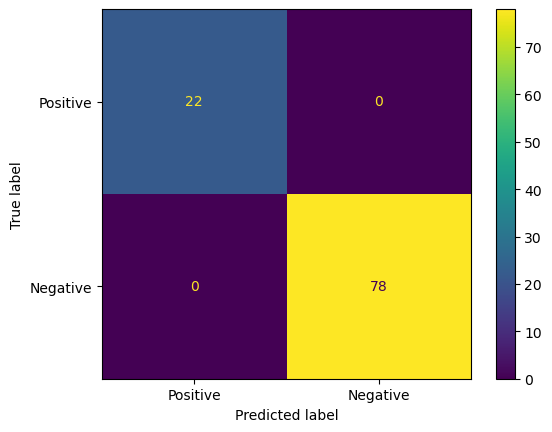

In [9]:
program_template = Program_Template(p_a, rules, T=3)
dilp = DILP(language_frame, B, P, N, program_template, allow_target_recursion=True)
train(dilp)
test(dilp, input_table, con)

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 1.161202311515808
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Target(45) Expected: 1 1.000
Target(44) Expected: 1 1.000
Target(59) Expected: 0 0.859
Target(95) Expected: 0 0.859
Target(69) Expected: 1 1.000
Target(14) Expected: 0 0.726
Target(64) Expected: 1 1.000
Target(76) Expected: 0 0.859
Target(92) Expected: 0 0.726
Target(51) Expected: 0 0.859
Target(33) Expected: 0 0.859
Target(15) Expected: 0 0.726
Target(93) Expected: 0 0.726
Target(21) Expected: 0 0.859
Target(25) Expected: 1 1.000
Target(36) Expected: 1 1.000
Target(41) Expected: 0 0.859
Target(43) Expected: 1 1.000
Target(22) Expected: 0 0.726
Target(66) Expected: 0 0.726
Target(50

'select "B" and "A" as "Target",\n'

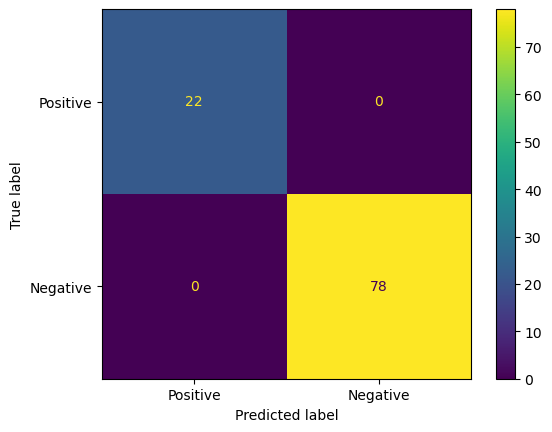

In [10]:
program_template = Program_Template(p_a, rules, T=5)
dilp = DILP(language_frame, B, P, N, program_template, allow_target_recursion=True)
train(dilp)
test(dilp, input_table, con)

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 1.309632420539856
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Target(45) Expected: 1 1.000
Target(44) Expected: 1 1.000
Target(59) Expected: 0 0.817
Target(95) Expected: 0 0.817
Target(69) Expected: 1 1.000
Target(14) Expected: 0 0.872
Target(64) Expected: 1 1.000
Target(76) Expected: 0 0.817
Target(92) Expected: 0 0.872
Target(51) Expected: 0 0.817
Target(33) Expected: 0 0.817
Target(15) Expected: 0 0.872
Target(93) Expected: 0 0.872
Target(21) Expected: 0 0.817
Target(25) Expected: 1 1.000
Target(36) Expected: 1 1.000
Target(41) Expected: 0 0.817
Target(43) Expected: 1 1.000
Target(22) Expected: 0 0.872
Target(66) Expected: 0 0.872
Target(50

'select "B" and "A" as "Target",\n'

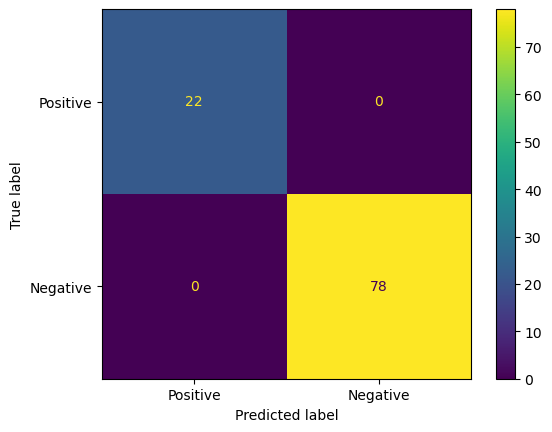

In [11]:
program_template = Program_Template(p_a, rules, T=10)
dilp = DILP(language_frame, B, P, N, program_template, allow_target_recursion=True)
train(dilp)
test(dilp, input_table, con)